Processing frames:   0%|          | 11/6280 [00:27<3:59:41,  2.29s/it]

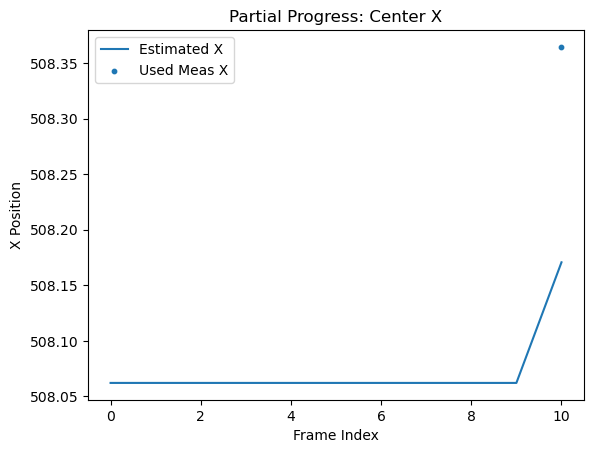

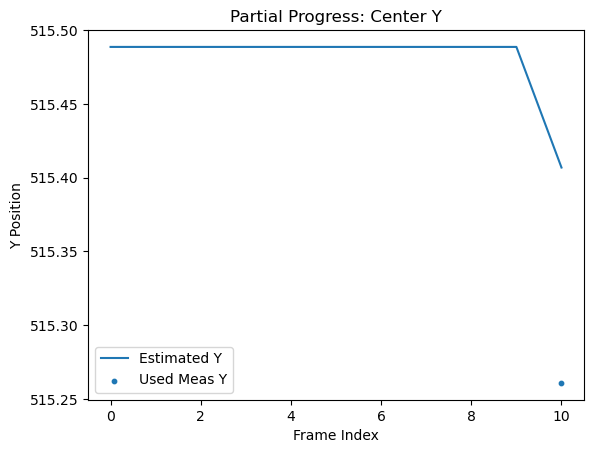

Processing frames:   0%|          | 22/6280 [00:39<2:36:41,  1.50s/it]

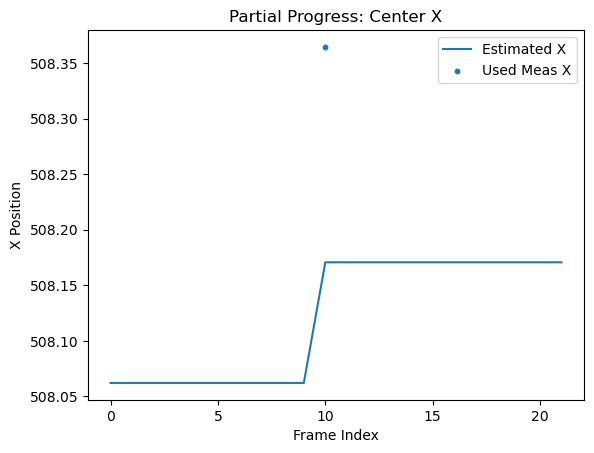

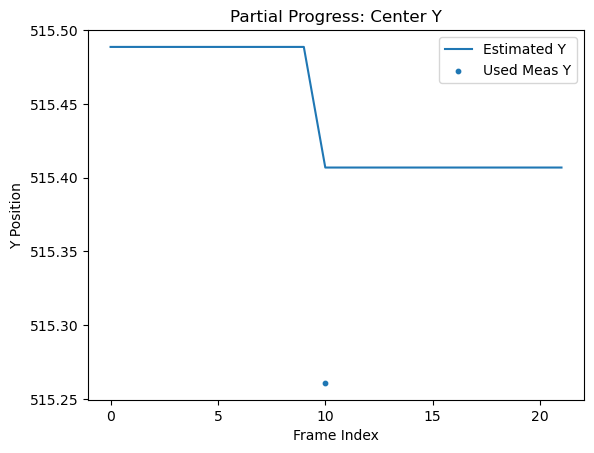

Processing frames:   1%|          | 33/6280 [00:51<2:14:00,  1.29s/it]

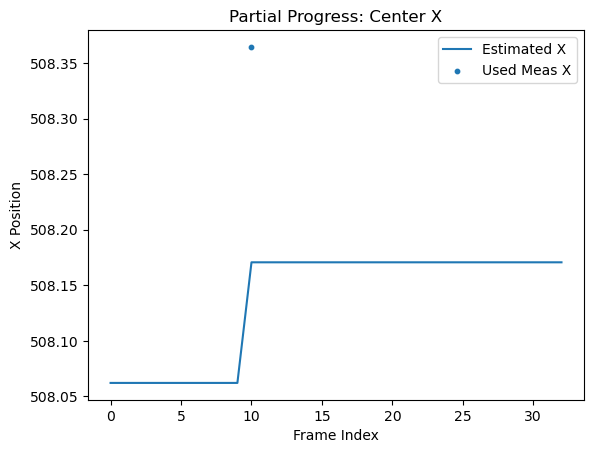

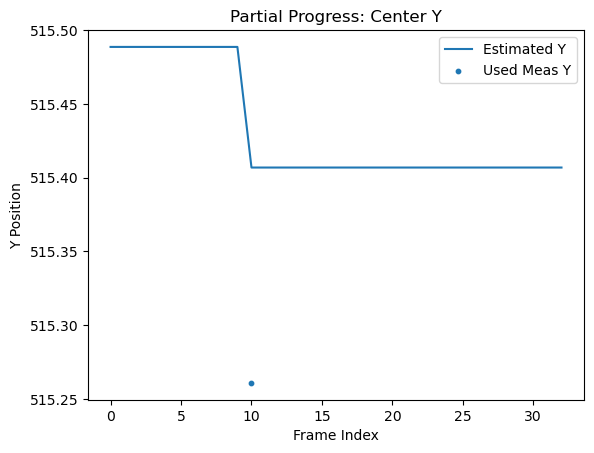

Processing frames:   1%|          | 44/6280 [01:05<2:13:49,  1.29s/it]

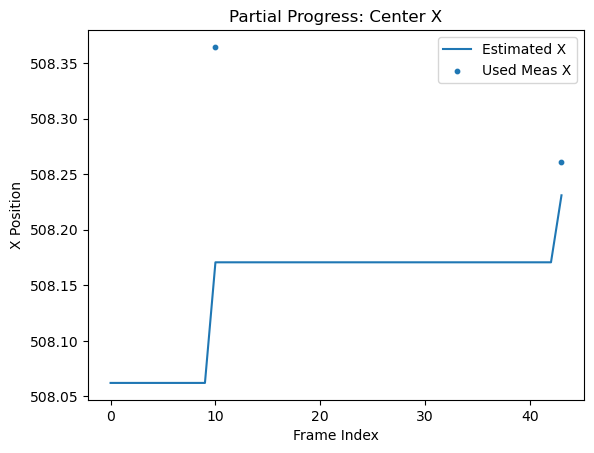

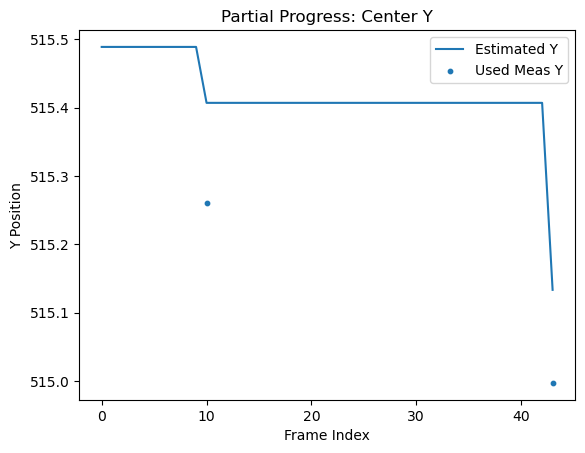

Processing frames:   1%|          | 55/6280 [01:18<2:11:36,  1.27s/it]

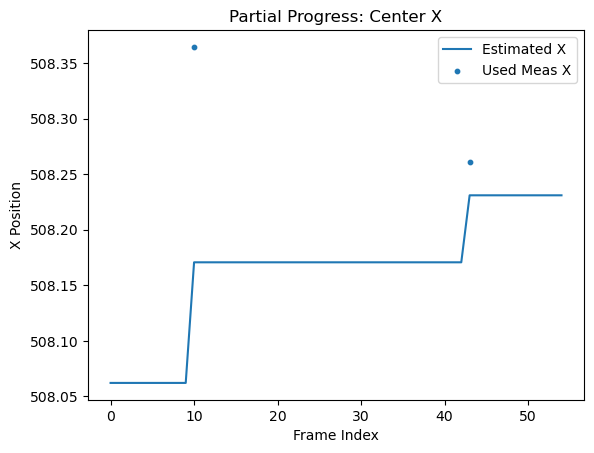

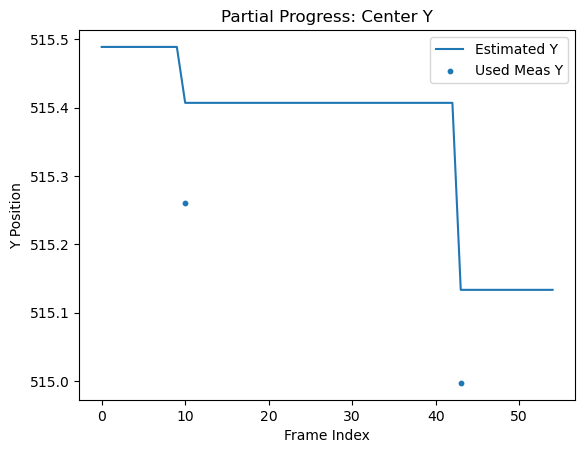

Processing frames:   1%|          | 66/6280 [01:29<1:55:08,  1.11s/it]

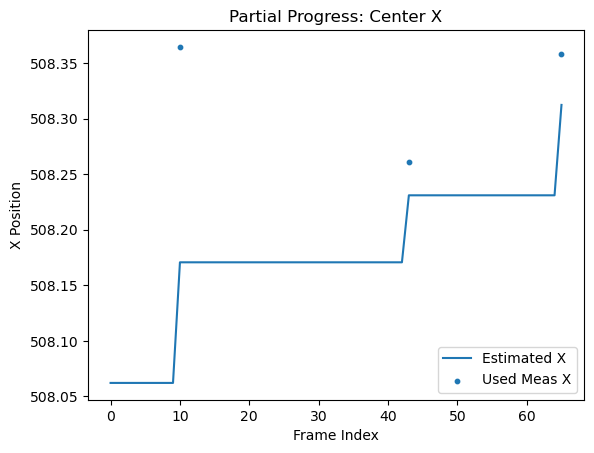

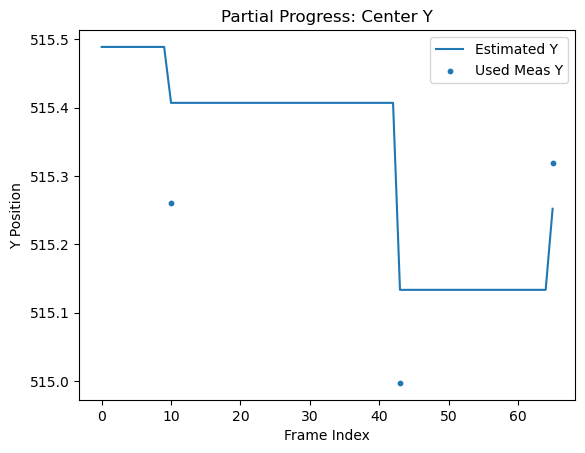

Processing frames:   2%|▏         | 108/6280 [01:47<57:05,  1.80it/s] 

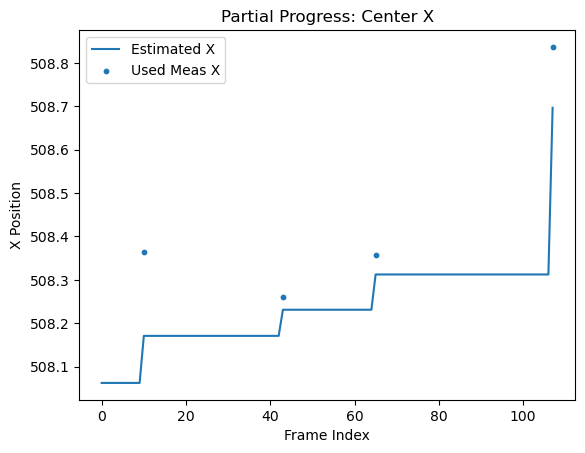

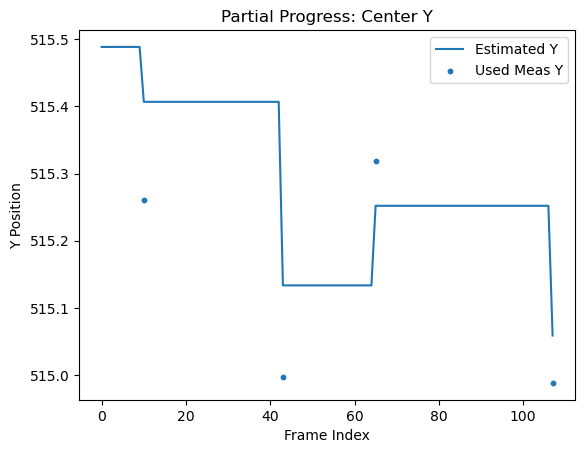

Processing frames:   2%|▏         | 119/6280 [02:01<1:21:12,  1.26it/s]

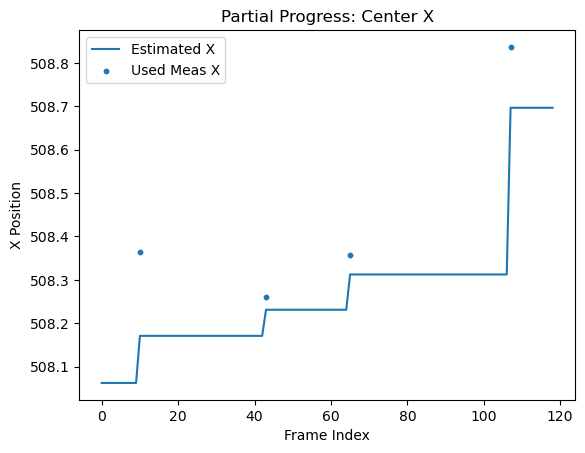

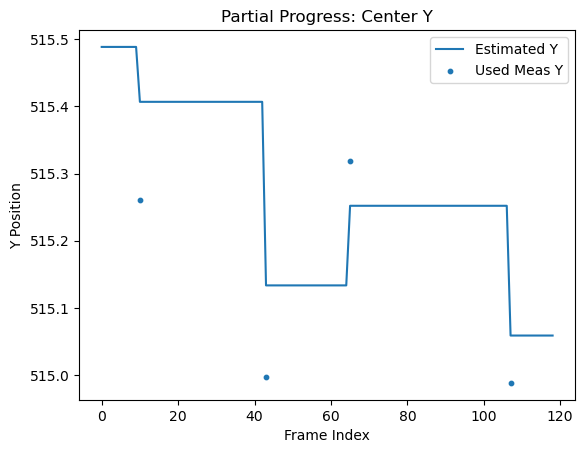

Processing frames:   2%|▏         | 130/6280 [02:12<1:33:00,  1.10it/s]

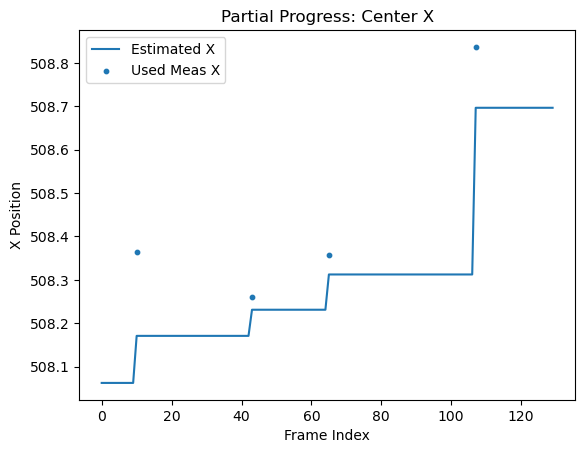

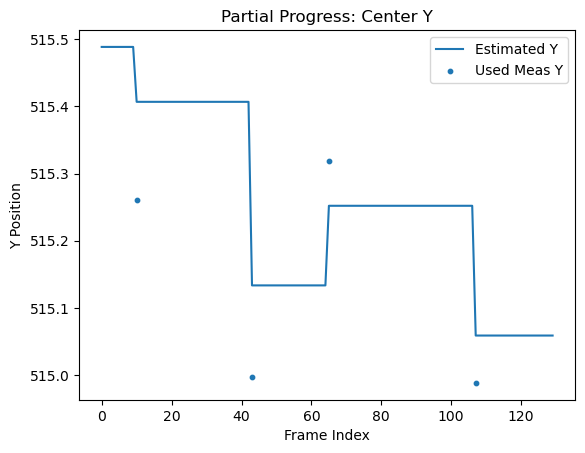

Processing frames:   2%|▏         | 141/6280 [02:26<1:48:49,  1.06s/it]

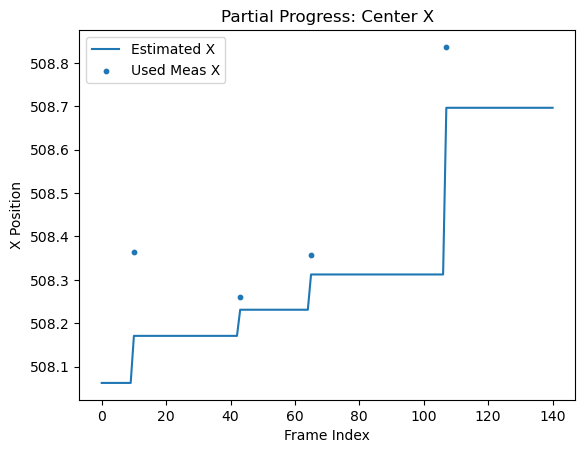

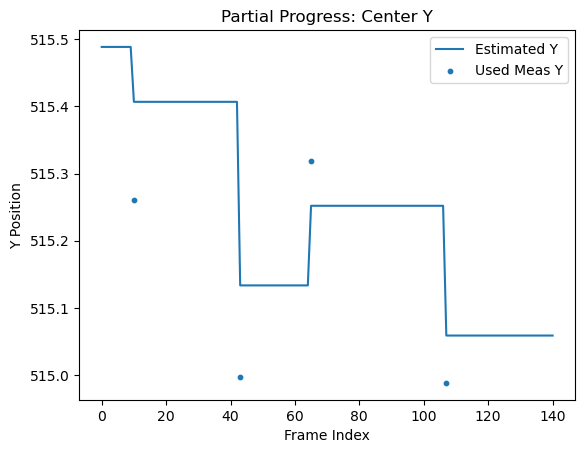

Processing frames:   2%|▏         | 152/6280 [02:40<2:03:19,  1.21s/it]

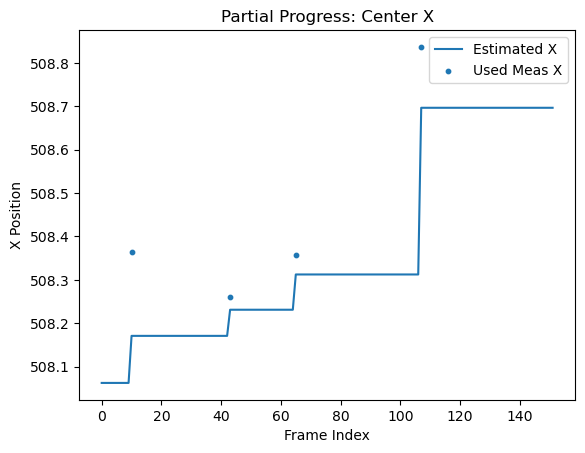

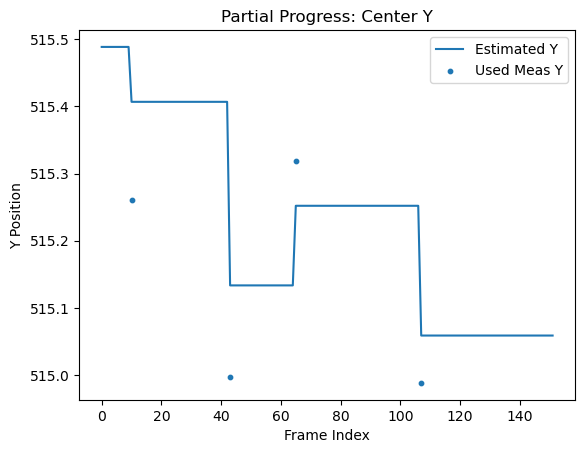

Processing frames:   3%|▎         | 174/6280 [02:58<1:35:27,  1.07it/s]

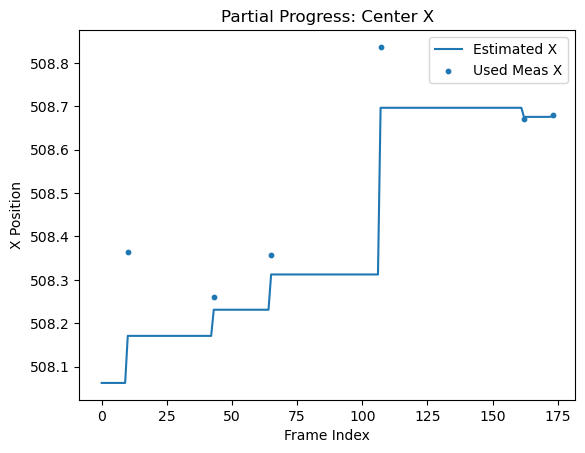

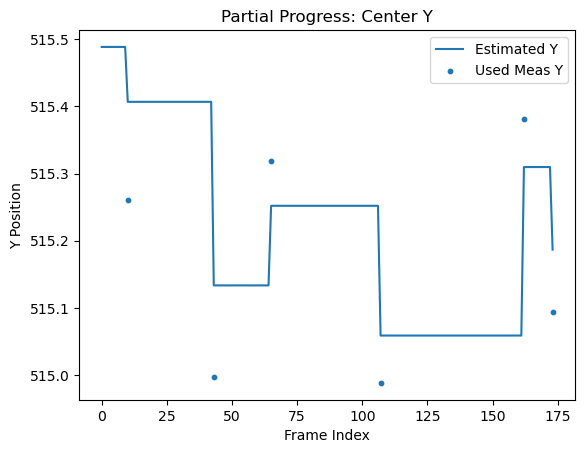

Processing frames:   3%|▎         | 195/6280 [03:12<1:17:19,  1.31it/s]

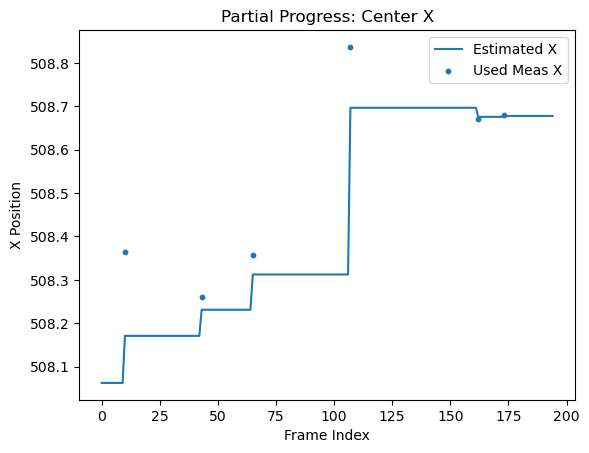

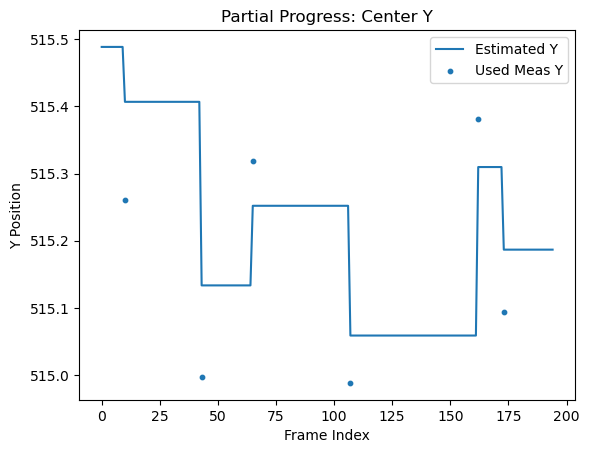

Processing frames:   4%|▍         | 237/6280 [03:38<1:08:17,  1.47it/s]

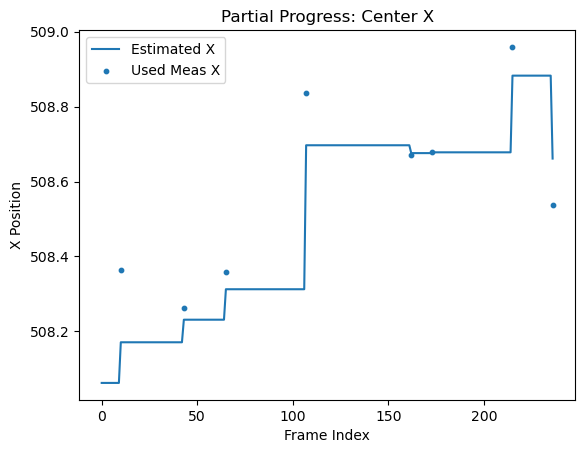

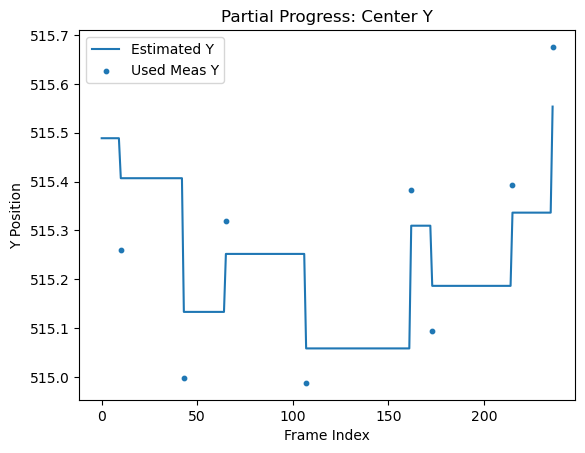

Processing frames:   4%|▍         | 258/6280 [03:54<1:13:05,  1.37it/s]

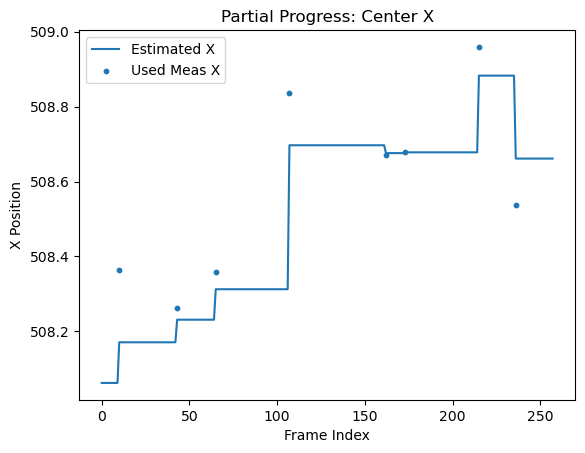

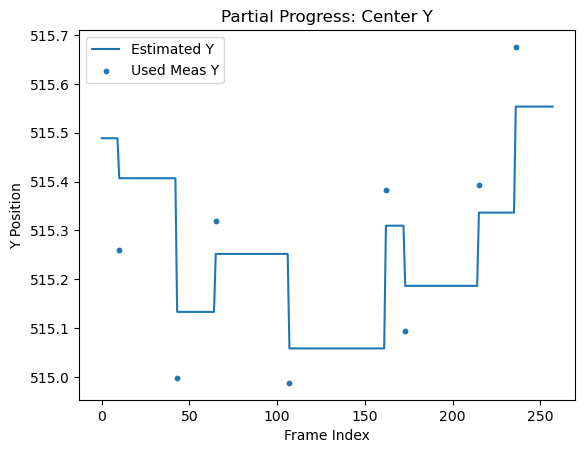

Processing frames:   4%|▍         | 279/6280 [04:04<1:01:22,  1.63it/s]

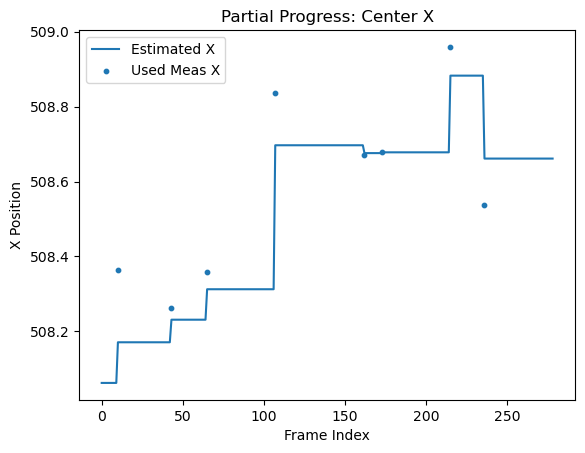

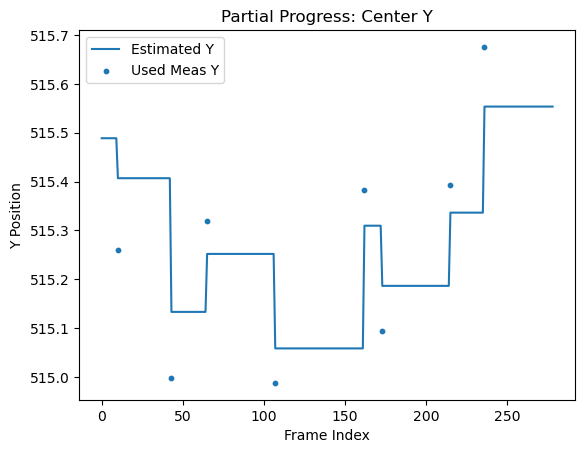

Processing frames:   5%|▍         | 300/6280 [04:15<55:52,  1.78it/s]  

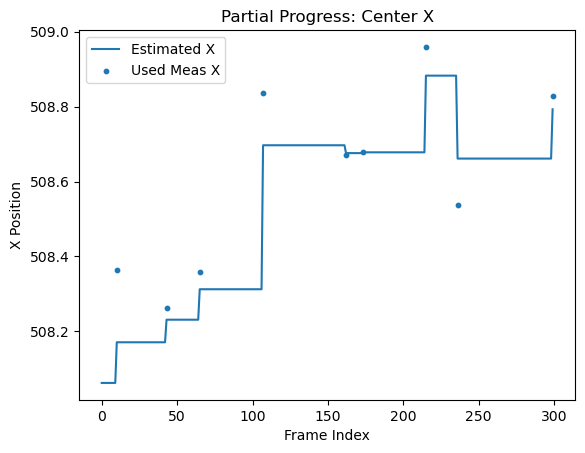

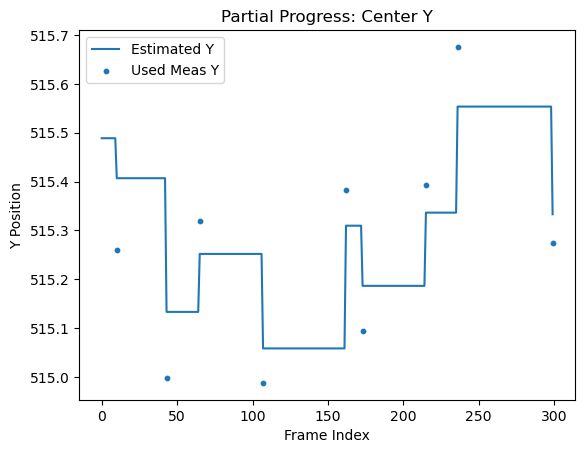

Processing frames:   5%|▌         | 321/6280 [04:25<52:54,  1.88it/s]

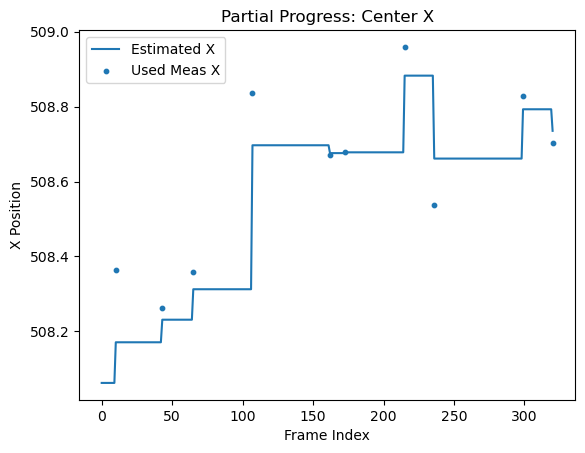

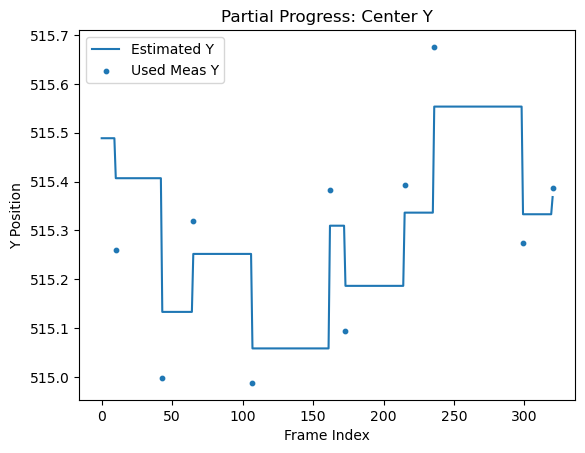

Processing frames:   6%|▌         | 362/6280 [04:43<46:08,  2.14it/s]

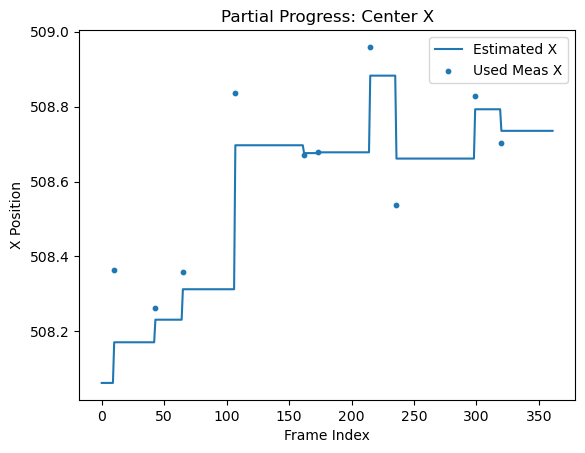

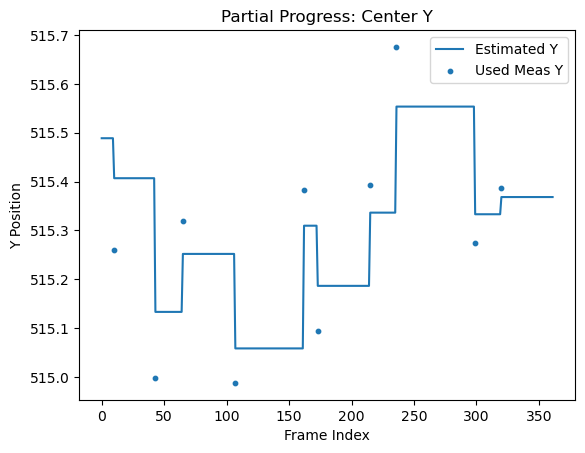

Processing frames:   6%|▋         | 403/6280 [04:56<37:05,  2.64it/s]

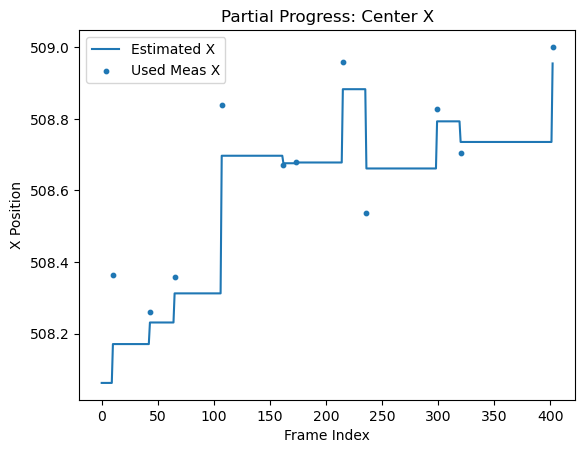

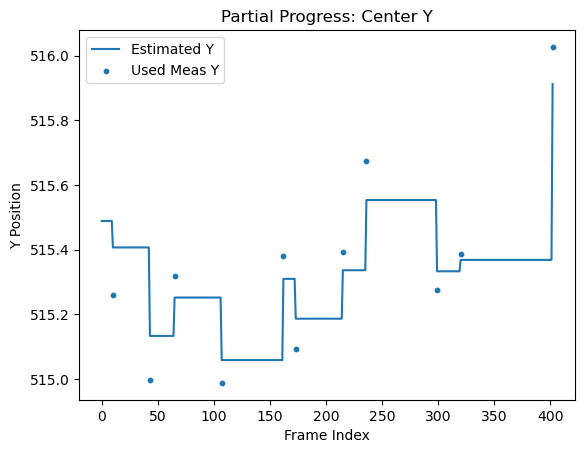

Processing frames:   7%|▋         | 424/6280 [05:11<49:26,  1.97it/s]

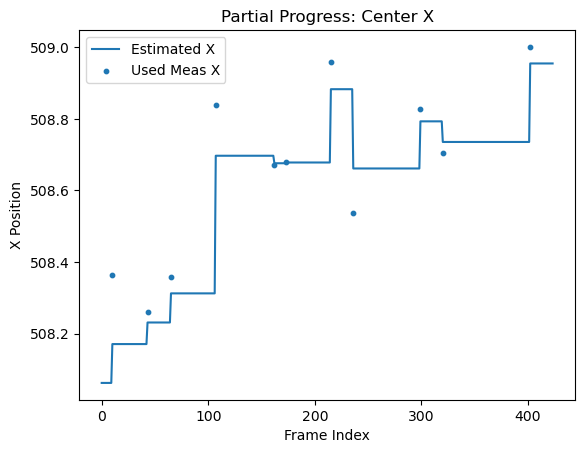

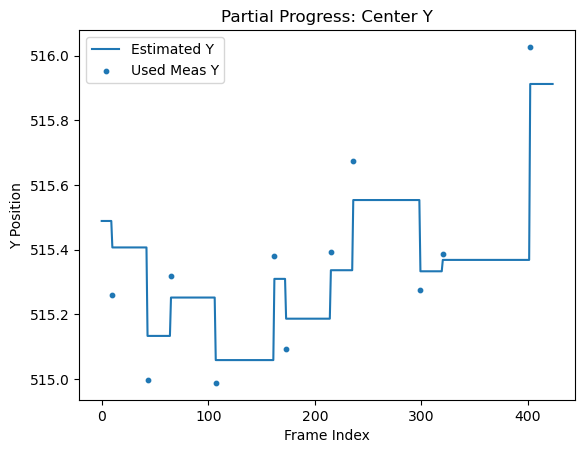

Processing frames:   7%|▋         | 445/6280 [05:23<53:32,  1.82it/s]

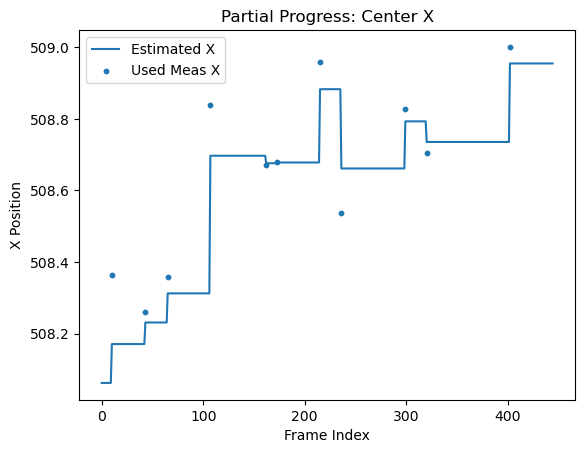

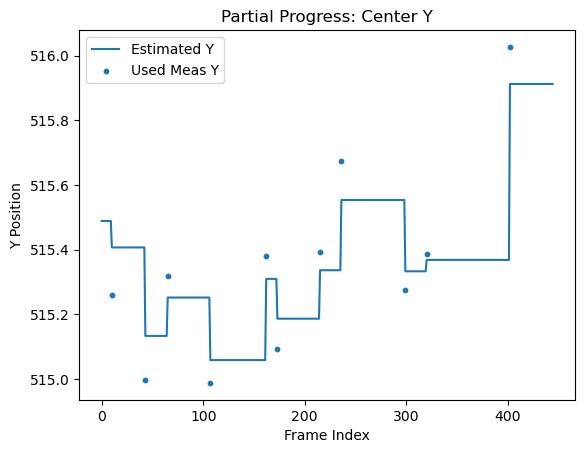

Processing frames:   7%|▋         | 466/6280 [05:34<50:55,  1.90it/s]

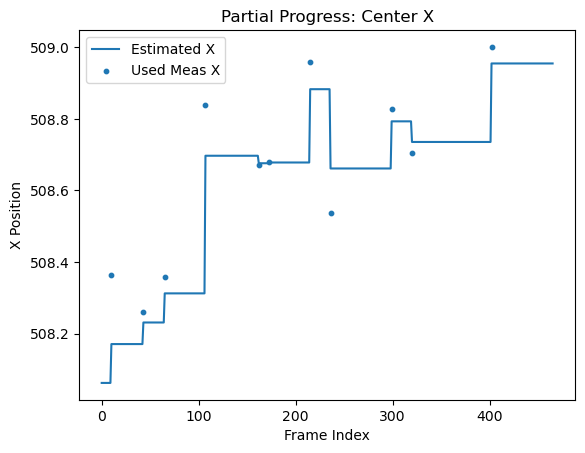

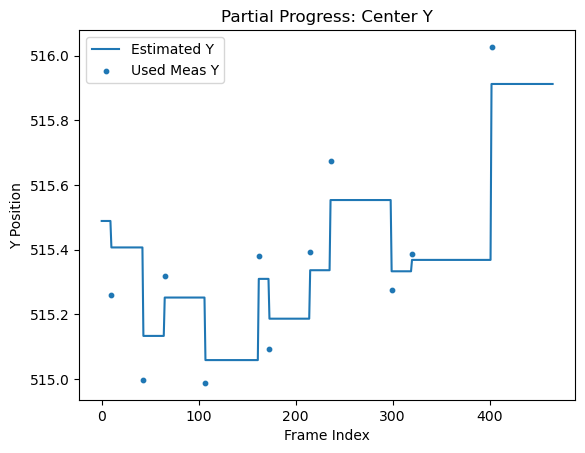

Processing frames:   7%|▋         | 467/6280 [05:34<49:39,  1.95it/s]

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# ===================================================================
#               Center-finding Functions & Helpers
# ===================================================================

def center_of_mass_initial_guess(image, mask):
    """
    Simple center-of-mass guess within the masked region.
    """
    masked_img = image[mask]
    coords = np.indices(image.shape)
    x_coords = coords[1][mask]
    y_coords = coords[0][mask]
    total = np.sum(masked_img)
    if total > 0:
        x_c = np.sum(x_coords * masked_img) / total
        y_c = np.sum(y_coords * masked_img) / total
        return (x_c, y_c)
    else:
        # fallback to geometric center if mask is empty
        return (image.shape[1] / 2.0, image.shape[0] / 2.0)


import numba

@numba.njit
def compute_bin_medians(wedge_vals, bin_indices, n_bins):
    result = np.empty(n_bins, dtype=np.float64)
    for bin_i in range(n_bins):
        count = 0
        for j in range(wedge_vals.shape[0]):
            if bin_indices[j] == bin_i:
                count += 1
        if count == 0:
            result[bin_i] = np.nan
        else:
            tmp = np.empty(count, dtype=np.float64)
            k = 0
            for j in range(wedge_vals.shape[0]):
                if bin_indices[j] == bin_i:
                    tmp[k] = wedge_vals[j]
                    k += 1
            tmp.sort()
            if count % 2 == 1:
                result[bin_i] = tmp[count // 2]
            else:
                result[bin_i] = 0.5 * (tmp[count // 2 - 1] + tmp[count // 2])
    return result


def compute_wedge_radial_profiles_shifted(
    image, mask, base_center, shift, dx_base, dy_base,
    n_wedges=8, n_rad_bins=200, r_max=None
):
    new_dx = dx_base - shift[0]
    new_dy = dy_base - shift[1]
    r = np.sqrt(new_dx**2 + new_dy**2)
    theta = np.arctan2(new_dy, new_dx)
    
    if r_max is None:
        r_max = min(image.shape) / 2.0
    r_edges = np.linspace(0, r_max, n_rad_bins+1)
    
    wedge_profiles = []
    wedge_step = 2 * np.pi / n_wedges
    
    for w in range(n_wedges):
        angle_min = -np.pi + w * wedge_step
        angle_max = -np.pi + (w+1) * wedge_step
        
        wedge_mask = (theta >= angle_min) & (theta < angle_max) & mask
        r_wedge = r[wedge_mask]
        wedge_vals = image[wedge_mask]
        
        bin_indices = np.digitize(r_wedge, r_edges) - 1
        profile = compute_bin_medians(wedge_vals, bin_indices, n_wedges * 0) # just a placeholder
        # Correction: we must use n_rad_bins, not n_wedges * 0.
        # That was a simple placeholder. Let's fix that:
        profile = compute_bin_medians(wedge_vals, bin_indices, n_rad_bins)
        
        wedge_profiles.append(profile)
    r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])
    return wedge_profiles, r_centers


def find_best_center_shift_vectorized(
    image, mask, current_center, base_center, dx_base, dy_base,
    step_size=1.0, n_steps=3, n_wedges=4, n_rad_bins=100
):
    shift_vals = np.linspace(-step_size, step_size, n_steps)
    DX, DY = np.meshgrid(shift_vals, shift_vals)
    candidate_shifts = np.column_stack((DX.ravel(), DY.ravel()))
    
    best_shift = None
    best_metric = np.inf
    
    current_offset = (
        current_center[0] - base_center[0],
        current_center[1] - base_center[1]
    )
    
    for candidate in candidate_shifts:
        eff_shift = (current_offset[0] + candidate[0],
                     current_offset[1] + candidate[1])
        
        wedge_profiles, _ = compute_wedge_radial_profiles_shifted(
            image, mask, base_center, eff_shift, dx_base, dy_base,
            n_wedges=n_wedges, n_rad_bins=n_rad_bins
        )
        
        # Compare opposite wedges to get misalignment metric
        half = n_wedges // 2
        total_diff = 0.0
        count = 0
        for i in range(half):
            p1 = wedge_profiles[i]
            p2 = wedge_profiles[i + half]
            valid = ~np.isnan(p1) & ~np.isnan(p2)
            if np.any(valid):
                diff = p1[valid] - p2[valid]
                total_diff += np.sum(diff**2)
                count += np.sum(valid)
        metric = total_diff / count if count > 0 else np.inf
        
        if metric < best_metric:
            best_metric = metric
            best_shift = candidate
    
    return best_shift


def find_diffraction_center(
    image,
    mask,
    threshold=0.01,
    max_iters=10,
    step_size=1.0,
    n_steps=3,
    n_wedges=8,
    n_rad_bins=200,
    verbose=False
):
    """
    Iteratively refines the center by comparing opposite wedge profiles.
    """
    rows, cols = np.indices(image.shape)
    base_center = center_of_mass_initial_guess(image, mask)

    dx_base = cols - base_center[0]
    dy_base = rows - base_center[1]

    center = base_center
    for iteration in range(max_iters):
        candidate_shift = find_best_center_shift_vectorized(
            image, mask, center, base_center,
            dx_base, dy_base,
            step_size=step_size,
            n_steps=n_steps,
            n_wedges=n_wedges,
            n_rad_bins=n_rad_bins
        )
        dx, dy = candidate_shift
        shift_mag = np.sqrt(dx ** 2 + dy ** 2)
        center = (center[0] + dx, center[1] + dy)
        
        if shift_mag < threshold:
            center = (float(center[0]), float(center[1]))
            if verbose:
                print(f"[find_diffraction_center] Converged at iteration {iteration+1} center={center}")
            break
    return center


def load_mask(mask_file):
    """
    Loads a SINGLE 2D mask from HDF5. If the dataset is 3D, we take the first slice.
    """
    with h5py.File(mask_file, "r") as hf:
        m = hf["/mask"][:]
    # If there's a first dimension, drop it
    if m.ndim > 2:
        m = m[0]
    return m.astype(bool)


# ===================================================================
#            Parallel Measurement (Frame-by-Frame)
# ===================================================================

def measurement_task(
    local_index,
    images_chunk,
    mask,
    chunk_start,
    threshold,
    max_iters,
    step_size,
    n_steps,
    n_wedges,
    n_rad_bins
):
    """
    Parallel "expensive" measurement for the frame at absolute index = chunk_start + local_index
    but we only pass the chunk array 'images_chunk' of shape (chunk_len, height, width).

    Returns (absolute_frame_index, (cx, cy)).
    """
    # If you want to simulate slow compute:
    # time.sleep(random.uniform(1.0, 2.0))

    image = images_chunk[local_index]  
    center = find_diffraction_center(
        image,
        mask,
        threshold=threshold,
        max_iters=max_iters,
        step_size=step_size,
        n_steps=n_steps,
        n_wedges=n_wedges,
        n_rad_bins=n_rad_bins
    )

    abs_frame_index = chunk_start + local_index
    return (abs_frame_index, center)


# ===================================================================
#          Adaptive Sampling + Kalman in a Chunked Loop
# ===================================================================

def adaptive_sampling_kalman_filter_parallel_chunked(
    image_file,
    mask_file,
    chunk_size=1000,
    process_noise=0.001,
    measurement_noise=0.1,
    gating_threshold=5.0,
    initial_interval=5,
    error_threshold=1.0,
    min_interval=1,
    max_interval=50,
    max_workers=4,
    # Diffraction center-finding params:
    center_threshold=0.01,
    center_max_iters=10,
    center_step_size=1.0,
    center_n_steps=3,
    center_n_wedges=8,
    center_n_rad_bins=200,
    # Partial plot settings
    partial_plot_interval_sec=10.0,
):
    """
    Reads the .h5 data in chunks of `chunk_size` frames, runs a global Kalman filter 
    with parallel measurements for frames that get sampled.

    We store the global (x_est, P_est, sampling_interval, etc.) across all chunks.
    Return a DataFrame with final results for all frames.
    """

    # Open image HDF5 in read mode
    with h5py.File(image_file, "r") as hf:
        dataset_images = hf["/entry/data/images"]
        n_frames = dataset_images.shape[0]  # total frames

        # Load single 2D mask
        mask = load_mask(mask_file)

        # ================== Initialize Kalman Filter ==================
        # We'll do a blocking measurement on frame 0
        # so let's read just the first image from the dataset
        first_image = dataset_images[0].astype(np.float32)
        x0_center = find_diffraction_center(
            first_image,
            mask,
            threshold=center_threshold,
            max_iters=center_max_iters,
            step_size=center_step_size,
            n_steps=center_n_steps,
            n_wedges=center_n_wedges,
            n_rad_bins=center_n_rad_bins
        )
        x_est = np.array([x0_center[0], x0_center[1]], dtype=float)
        P_est = 0.01 * np.eye(2)

        # Adaptive sampling state
        sampling_interval = initial_interval
        frames_since_last_measurement = 0

        # Kalman matrices
        F = np.eye(2)
        H = np.eye(2)
        Q = process_noise * np.eye(2)
        R = measurement_noise * np.eye(2)

        # We'll store records for all frames in memory:
        output_records = []
        columns = [
            'frame_index',
            'meas_x', 'meas_y',
            'est_x', 'est_y',
            'took_measurement', 'used_measurement',
            'err_x', 'err_y'
        ]

        # ============ Baseline centers (if you want error vs. CoM) ============
        # We do NOT want to read all frames just to compute baseline CoM. 
        # If memory is an issue, you can skip or do a chunk-based approach:
        baseline_centers = [None] * n_frames  # to fill chunk by chunk

        last_plot_time = time.time()

        # -------------- Create a ProcessPool once for all frames --------------
        with ProcessPoolExecutor(max_workers=max_workers) as executor:

            # We'll show a progress bar for all frames
            with tqdm(total=n_frames, desc="Processing frames") as pbar:

                # =============== Outer loop over CHUNKS ===============
                for chunk_start in range(0, n_frames, chunk_size):
                    chunk_end = min(n_frames, chunk_start + chunk_size)
                    # load chunk into memory
                    images_chunk = dataset_images[chunk_start:chunk_end].astype(np.float32)
                    chunk_len = chunk_end - chunk_start

                    # Also compute baseline CoM for frames in this chunk (if desired)
                    # We'll store them in baseline_centers[abs_idx].
                    # This is optional if you want that "err_x/err_y" vs. CoM:
                    for local_i in range(chunk_len):
                        abs_i = chunk_start + local_i
                        c0 = center_of_mass_initial_guess(images_chunk[local_i], mask)
                        baseline_centers[abs_i] = c0

                    # =============== Inner loop over chunk frames ===============
                    for local_i in range(chunk_len):
                        i = chunk_start + local_i
                        
                        # 1) Predict
                        x_pred = F @ x_est
                        P_pred = F @ P_est @ F.T + Q

                        took_measurement = False
                        used_measurement = False
                        meas_x, meas_y = (np.nan, np.nan)

                        # 2) Decide if we measure
                        if frames_since_last_measurement >= sampling_interval:
                            took_measurement = True
                            # Submit parallel measurement
                            future = executor.submit(
                                measurement_task,
                                local_i,
                                images_chunk,  # the chunk array
                                mask,
                                chunk_start,
                                center_threshold,
                                center_max_iters,
                                center_step_size,
                                n_steps=center_n_steps,
                                n_wedges=center_n_wedges,
                                n_rad_bins=center_n_rad_bins
                            )
                            abs_frame_idx, measured_center = future.result()

                            # 3) Outlier gating
                            z_true = np.array([measured_center[0], measured_center[1]])
                            S = P_pred + R
                            y_residual = z_true - x_pred
                            try:
                                dist = y_residual @ np.linalg.inv(S) @ y_residual
                            except np.linalg.LinAlgError:
                                dist = np.inf

                            if dist <= gating_threshold:
                                used_measurement = True
                                meas_x, meas_y = z_true[0], z_true[1]
                                # Kalman update
                                K = P_pred @ np.linalg.inv(S)
                                x_est = x_pred + K @ y_residual
                                P_est = (np.eye(2) - K) @ P_pred

                                # Adaptive sampling logic
                                error_mag = np.linalg.norm(z_true - x_pred)
                                if error_mag > error_threshold:
                                    sampling_interval = max(min_interval, sampling_interval // 2)
                                elif error_mag < (error_threshold / 2.0):
                                    sampling_interval = min(max_interval, sampling_interval * 2)
                            else:
                                # outlier
                                x_est = x_pred
                                P_est = P_pred

                            frames_since_last_measurement = 0
                        else:
                            # no measurement
                            x_est = x_pred
                            P_est = P_pred
                            frames_since_last_measurement += 1

                        # 4) For demonstration, compute error vs. baseline CoM
                        bx, by = baseline_centers[i]
                        err_x = x_est[0] - bx
                        err_y = x_est[1] - by

                        output_records.append((
                            i, meas_x, meas_y,
                            x_est[0], x_est[1],
                            took_measurement, used_measurement,
                            err_x, err_y
                        ))

                        pbar.update(1)

                        # 5) Possibly do partial plotting
                        # check if enough time has passed
                        current_time = time.time()
                        if (current_time - last_plot_time) >= partial_plot_interval_sec:
                            last_plot_time = current_time
                            partial_df = pd.DataFrame(output_records, columns=columns)
                            
                            # Plot partial X
                            plt.figure()
                            plt.plot(partial_df['frame_index'], partial_df['est_x'],
                                     label='Estimated X', linestyle='-')
                            used_meas_mask = partial_df['used_measurement'].values
                            plt.scatter(partial_df['frame_index'][used_meas_mask],
                                        partial_df['meas_x'][used_meas_mask],
                                        label='Used Meas X', s=10)
                            plt.title("Partial Progress: Center X")
                            plt.xlabel("Frame Index")
                            plt.ylabel("X Position")
                            plt.legend()
                            plt.show()

                            # Plot partial Y
                            plt.figure()
                            plt.plot(partial_df['frame_index'], partial_df['est_y'],
                                     label='Estimated Y', linestyle='-')
                            plt.scatter(partial_df['frame_index'][used_meas_mask],
                                        partial_df['meas_y'][used_meas_mask],
                                        label='Used Meas Y', s=10)
                            plt.title("Partial Progress: Center Y")
                            plt.xlabel("Frame Index")
                            plt.ylabel("Y Position")
                            plt.legend()
                            plt.show()

        # End of all chunks
        out_df = pd.DataFrame(output_records, columns=columns)
        used_count = out_df["used_measurement"].sum()
        print(f"\n[Chunked Adaptive KF] Complete: {n_frames} frames total.")
        print(f"Measurements used: {used_count} of {n_frames} frames.")
        print(f"Final sampling interval was {sampling_interval}.")
        return out_df


# ===================================================================
#                         Example Usage
# ===================================================================

if __name__ == "__main__":
    # ----------------------------------------------------------------
    # Adjust these paths/parameters to match your setup
    # ----------------------------------------------------------------
    image_file = "/home/bubl3932/files/UOX1/UOX1_min_15_peak/UOX1_min_15_peak.h5"
    mask_file  = "/home/bubl3932/mask/pxmask.h5"

    # We want to process all frames in chunks of 1000 
    # to avoid loading the entire dataset in memory:
    chunk_size = 1000

    # Now run the chunked adaptive KF:
    result_df = adaptive_sampling_kalman_filter_parallel_chunked(
        image_file,
        mask_file,
        chunk_size=chunk_size,
        process_noise=0.05,
        measurement_noise=1.0,
        gating_threshold=0.1,
        initial_interval=10,
        error_threshold=0.5,
        min_interval=1,
        max_interval=100,
        max_workers=4,
        center_threshold=0.01,
        center_max_iters=10,
        center_step_size=1.0,
        center_n_steps=3,
        center_n_wedges=8,
        center_n_rad_bins=200,
        partial_plot_interval_sec=10.0  # partial plot every 10 seconds
    )

    # Show the final few records
    print("\nFinal results (head):")
    print(result_df.head())
    print("\nFinal results (tail):")
    print(result_df.tail())

    # You can do a final overall plot 
    used_meas_mask = result_df['used_measurement']

    plt.figure()
    plt.plot(result_df['frame_index'], result_df['est_x'], label="Final Estimated X", linestyle="-")
    plt.scatter(result_df['frame_index'][used_meas_mask],
                result_df['meas_x'][used_meas_mask],
                label='Used Meas X', s=10)
    plt.title("Final: Estimated vs. Measured X (All Frames)")
    plt.xlabel("Frame Index")
    plt.ylabel("X Position")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(result_df['frame_index'], result_df['est_y'], label="Final Estimated Y", linestyle="-")
    plt.scatter(result_df['frame_index'][used_meas_mask],
                result_df['meas_y'][used_meas_mask],
                label='Used Meas Y', s=10)
    plt.title("Final: Estimated vs. Measured Y (All Frames)")
    plt.xlabel("Frame Index")
    plt.ylabel("Y Position")
    plt.legend()
    plt.show()
